<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/Image_segmentation_TF_Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is not mine, code from https://www.tensorflow.org/tutorials/images/segmentation
# just modified for GPU usage in Colab, and something to visualization

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-na7fzn9n
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-na7fzn9n
  Created wheel for tensorflow-examples: filename=tensorflow_examples-d20bb6fb4524bb5ddb0f73021fcffcbabf1d13df_-cp37-none-any.whl size=227315 sha256=220b57404e28bfd476ae6453929c919e3cedbae747be3fe849425d878a3cc57d
  Stored in directory: /tmp/pip-ephem-wheel-cache-hq1zk_c0/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6KV87W/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6KV87W/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for i in range(10):
  for image, mask in train.take(i):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

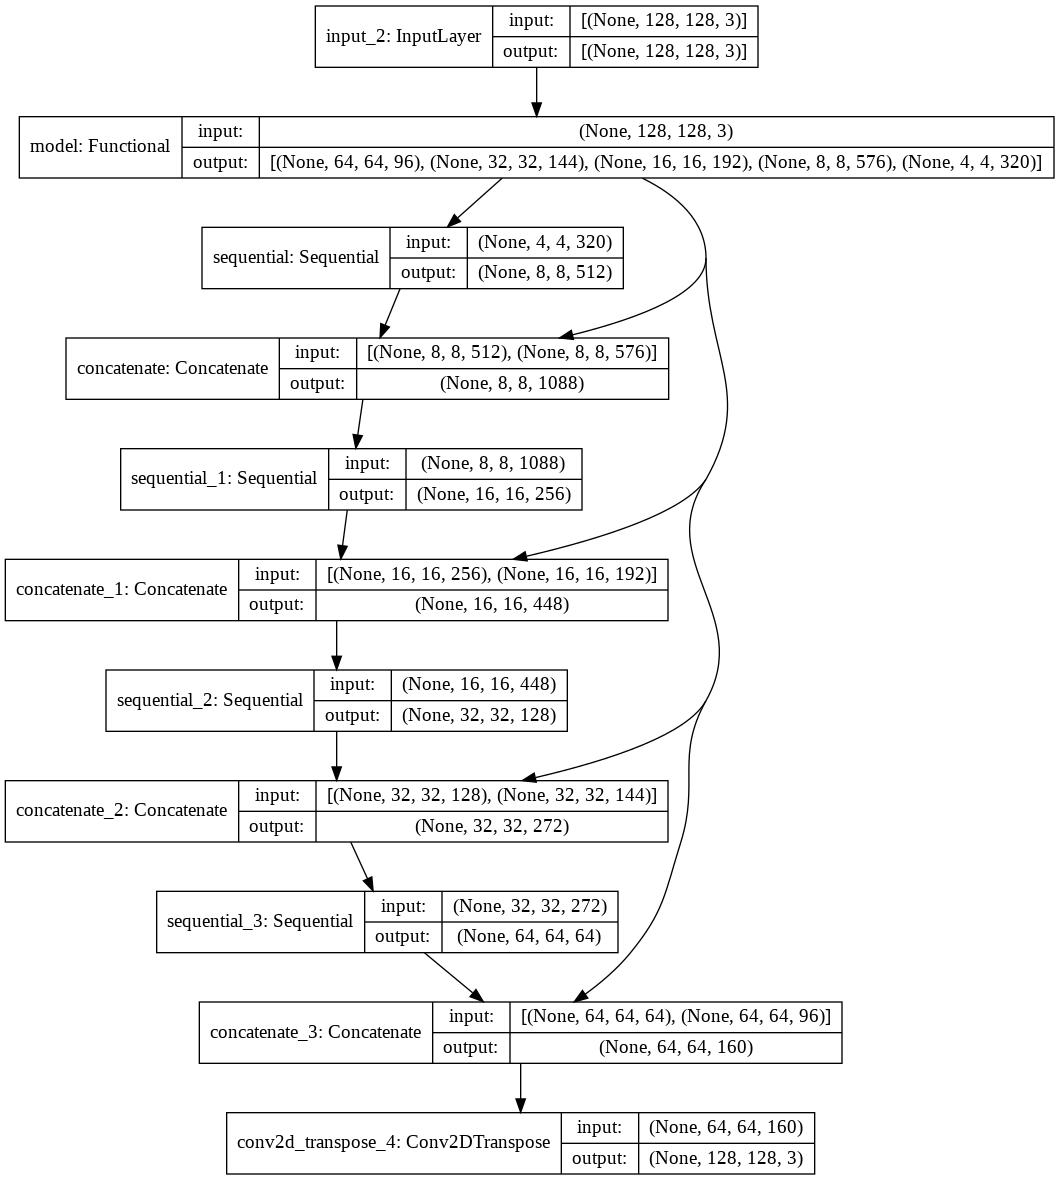

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
with tf.device('/device:GPU:0'):
  def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

  def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
      display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
  class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      #clear_output(wait=True)
      show_predictions()
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

  EPOCHS = 20
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()])

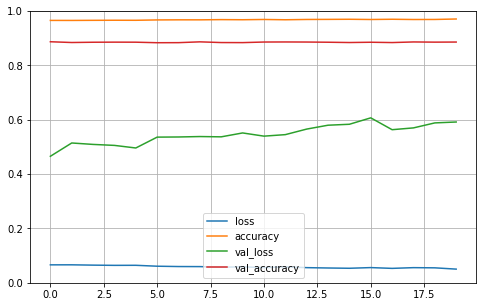

In [ ]:
# Learning curve (loss and accuracy)
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

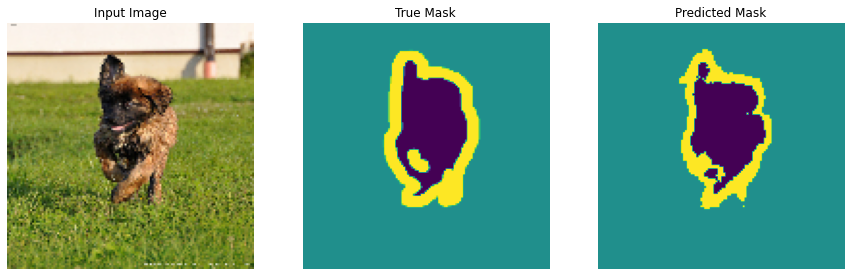

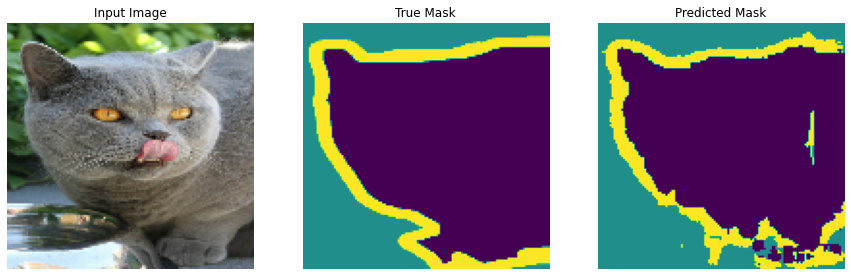

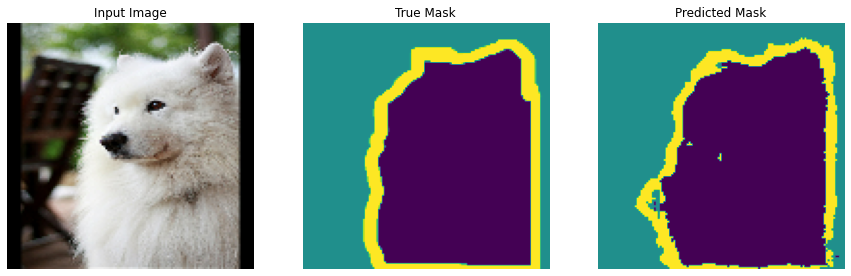

In [ ]:
show_predictions(test_dataset, 3)